In [2]:
import numpy as np
import sys
import os
sys.path.append(os.environ.get('OTF')+'/otf_engine')
import gp, env, struc, kernels, otf, md, md_run
sys.path.append(os.environ.get('OTF')+'/modules')
import qe_parsers, analyze_gp, eam, analyze_md, otf_parser, analyze_otf, otf_parser_v0, activation_parser, crystals
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import copy

In [3]:
# set font size
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 12}
plt.rc('font', **font)

# Cutoff test

In [3]:
two_file = \
    '/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Sweep_Two_Body_Cutoff_3'
three_file = \
    '/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Sweep_Three_Body_Cutoff_2'

two_noise = np.load(two_file+'/noise.npy')
two_err = np.load(two_file+'/test_errs.npy')
two_mse = np.load(two_file+'/mse.npy')
two_vars = np.load(two_file+'/vars.npy')
like = np.load(two_file+'/like.npy')

three_noise = np.load(three_file+'/noise.npy')
three_mse = np.load(three_file+'/mse.npy')
like_three = np.load(three_file+'/like.npy')
three_err = np.load(three_file+'/test_errs.npy')

cutoffs = np.arange(3.5, 8.1, 0.5)
three_cuts = np.arange(3.0, 4.6, 0.5)


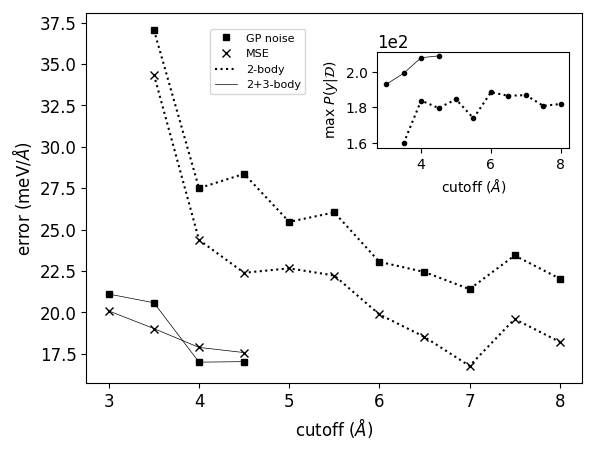

In [4]:
# error
fig, ax1 = plt.subplots()
ax1.set_xlabel('cutoff ($\AA$)')
ax1.set_ylabel('error (meV/$\AA$)')

ax1.plot(cutoffs, 1e3*np.abs(two_noise) ,'ks', label='GP noise', MarkerSize = 4)
ax1.plot(cutoffs, 1e3*np.abs(two_noise) ,'k:')
ax1.plot(cutoffs, 1e3*np.sqrt(two_mse), 'kx', label='MSE')
ax1.plot(cutoffs, 1e3*np.sqrt(two_mse), 'k:', label='2-body')

ax1.plot(three_cuts, 1e3*three_noise, 'ks', MarkerSize = 4)
ax1.plot(three_cuts, 1e3*three_noise, 'k-', label='2+3-body', linewidth=0.5)
ax1.plot(three_cuts, 1e3*np.sqrt(three_mse), 'kx')
ax1.plot(three_cuts, 1e3*np.sqrt(three_mse), 'k-', linewidth=0.5)

# ax1.text(2.95, 22, '2+3-body')
# ax1.text(4.3, 29.5, '2-body')

# likelihood
ax3 = plt.axes([.58, .6, .3, .2])
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax3.text(6, 170, '2-body', fontsize=10)
# ax3.text(3.9, 195, '2+3-body', fontsize=10)


ax3.plot(cutoffs, like, 'k.')
ax3.plot(cutoffs, like, 'k:')
ax3.plot(three_cuts, like_three, 'k.')
ax3.plot(three_cuts, like_three, 'k-', linewidth=0.5)
ax3.set_xlabel('cutoff ($\AA$)', fontsize=10)
ax3.set_ylabel('max $P(y|\mathcal{D})$', fontsize=10)
ax3.tick_params(labelsize=10)

ax1.legend(loc=(0.25,0.78), fontsize=8)
# ax1.legend(loc='best', fontsize=8)
plt.show()

# Error vs training data

In [219]:
test_errs = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Training_Data/test_errs.npy')
std_avgs = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Training_Data/std_avgs.npy')
noise = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Training_Data/noise.npy')
mse = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Training_Data/mse.npy')

In [220]:
noise

array([-0.00058181, -0.01496673, -0.0360213 ,  0.00283139,  0.0248227 ,
        0.02240691,  0.01900561,  0.01938174,  0.01887351,  0.01885349,
        0.01736208,  0.0151086 ,  0.0139065 ,  0.01582771,  0.01529985,
        0.01347703,  0.01358661,  0.01359642,  0.01364985,  0.01574934,
        0.01523254,  0.01577199,  0.01629219,  0.01639894,  0.01633562,
        0.01640133,  0.01610269,  0.0164982 ,  0.01682068,  0.01698832,
        0.01689995,  0.01672827])

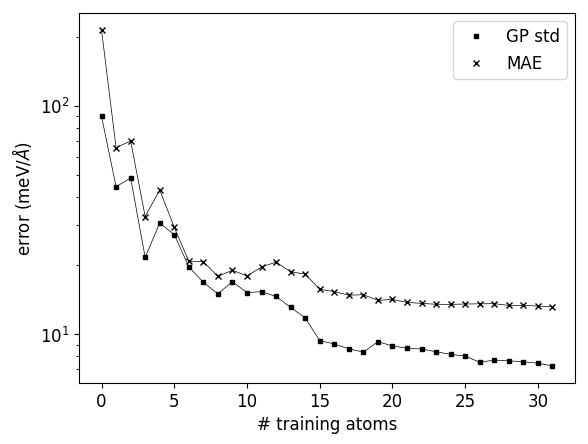

In [224]:
endpt = 30
# plt.plot(list(range(32)), np.sqrt(mse), '.')
plt.plot(1e3*std_avgs, 'ks', label='GP std', markersize=3)
plt.plot(1e3*std_avgs, 'k-', linewidth=0.5)
plt.plot(list(range(32)), 1e3*test_errs, 'kx', label='MAE', markersize=5)
plt.plot(list(range(32)), 1e3*test_errs, 'k-', linewidth=0.5)
plt.ylabel('error (meV/$\AA$)')
plt.xlabel('# training atoms')
# plt.axhline(1e3*0.01672827, color='k',linestyle=':')

plt.legend()
plt.yscale('log')
plt.show()

# Error vs perturbation size

In [226]:
test_errs = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Extrapolate/test_errs.npy')
mse = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Extrapolate/mses.npy')
std_avgs = np.load('/Users/jonpvandermause/Research/GP/otf/paper/Cutoff_Calibration/Extrapolate/std_avgs.npy')

In [227]:
pert_sizes = np.linspace(0.01, 0.09, 9)
pert_sizes

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

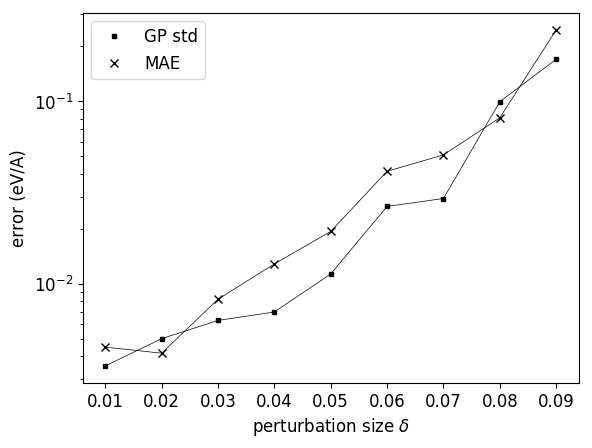

In [228]:
plt.plot(pert_sizes, std_avgs, 'ks', label='GP std', markersize=3)
plt.plot(pert_sizes, std_avgs, 'k-', linewidth=0.5)
plt.plot(pert_sizes, test_errs, 'kx', label='MAE')
plt.plot(pert_sizes, test_errs, 'k-', linewidth=0.5)
plt.yscale('log')
plt.xlabel('perturbation size $\delta$')
plt.ylabel('error (eV/A)')
plt.legend()
plt.show()

# Image tutorial

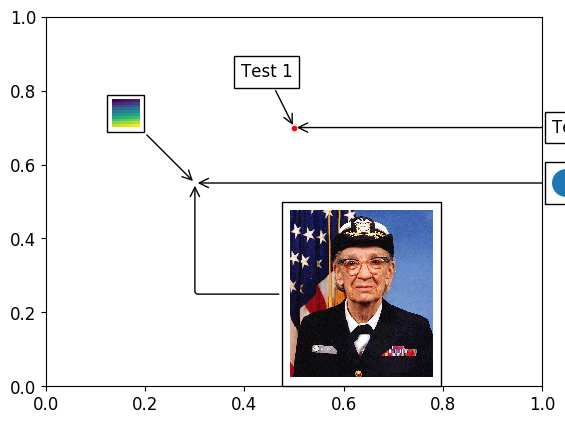

In [216]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data


if 1:
    fig, ax = plt.subplots()

    # Define a 1st position to annotate (display it with a marker)
    xy = (0.5, 0.7)
    ax.plot(xy[0], xy[1], ".r")

    # Annotate the 1st position with a text box ('Test 1')
    offsetbox = TextArea("Test 1", minimumdescent=False)

    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(-20, 40),
                        xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)

    # Annotate the 1st position with another text box ('Test')
    offsetbox = TextArea("Test", minimumdescent=False)

    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(1.02, xy[1]),
                        xycoords='data',
                        boxcoords=("axes fraction", "data"),
                        box_alignment=(0., 0.5),
                        arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)

    # Define a 2nd position to annotate (don't display with a marker this time)
    xy = [0.3, 0.55]

    # Annotate the 2nd position with a circle patch
    da = DrawingArea(20, 20, 0, 0)
    p = Circle((10, 10), 10)
    da.add_artist(p)

    ab = AnnotationBbox(da, xy,
                        xybox=(1.02, xy[1]),
                        xycoords='data',
                        boxcoords=("axes fraction", "data"),
                        box_alignment=(0., 0.5),
                        arrowprops=dict(arrowstyle="->"))

    ax.add_artist(ab)

    # Annotate the 2nd position with an image (a generated array of pixels)
    arr = np.arange(100).reshape((10, 10))
    im = OffsetImage(arr, zoom=2)
    im.image.axes = ax

    ab = AnnotationBbox(im, xy,
                        xybox=(-50., 50.),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.3,
                        arrowprops=dict(arrowstyle="->"))

    ax.add_artist(ab)

    # Annotate the 2nd position with another image (a Grace Hopper portrait)
    fn = get_sample_data("grace_hopper.png", asfileobj=False)
    arr_img = plt.imread(fn, format='png')

    imagebox = OffsetImage(arr_img, zoom=0.2)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, xy,
                        xybox=(120., -80.),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.5,
                        arrowprops=dict(
                            arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=3")
                        )

    ax.add_artist(ab)

    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.show()

# Temperature ramp

In [4]:
otf_file = \
    '/Users/jonpvandermause/Research/GP/data/Al_Temperature_Ramp/\
Al_Ramp2_3-26/otf_run.out'

# plot temperature on a log scale
otf_obj = otf_parser.OtfAnalysis(otf_file)


dft_times = otf_obj.dft_times
dft_frames = otf_obj.dft_frames
atom_count = otf_obj.gp_atom_count
temperatures = otf_obj.temperatures
msds = otf_obj.msds
times = otf_obj.times
uncertainties = otf_obj.uncertainty_list
dft_forces = otf_obj.gp_force_list
gp_forces = otf_obj.force_list

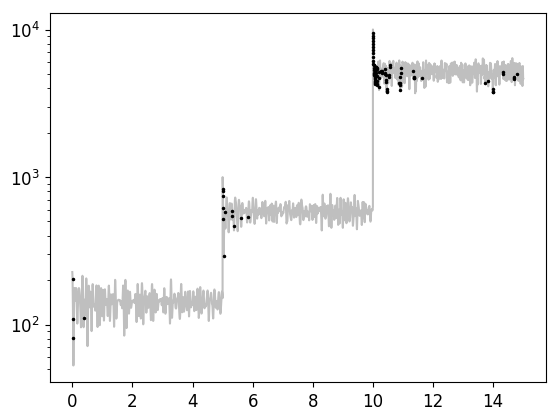

In [10]:
plt.plot(otf_obj.times, otf_obj.temperatures, 'k-', alpha=0.25)

dft_temps = [otf_obj.temperatures[n-1] for n in otf_obj.dft_frames[1:]]  # exclude first call
plt.plot(otf_obj.dft_times[1:], dft_temps, 'k.', MarkerSize=3)
plt.yscale('log')
# plt.xlim(0, 1)
plt.show()

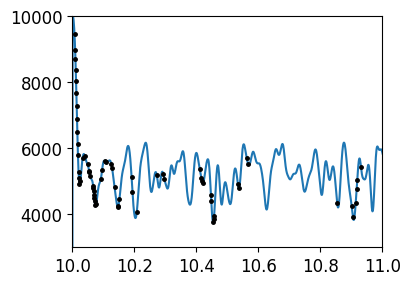

In [175]:
f = plt.figure()
plt.plot(otf_obj.times, otf_obj.temperatures)

dft_temps = [otf_obj.temperatures[n-1] for n in otf_obj.dft_frames[1:]]  # exclude first call
plt.plot(otf_obj.dft_times[1:], dft_temps, 'k.', MarkerSize=5)
# plt.yscale('log')
plt.xlim(10, 11)
f.set_size_inches(4, 3)
plt.ylim(3000, 10000)
plt.show()

# Learning Curve

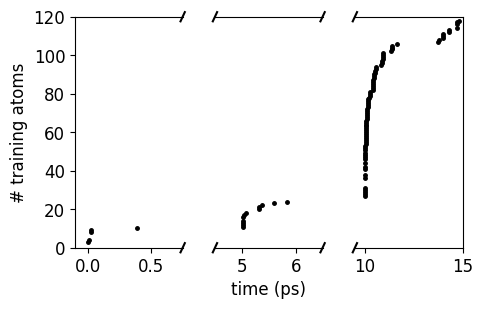

In [297]:
x = dft_times
y = np.cumsum(atom_count)

f,(ax,ax2,ax3) = plt.subplots(1,3,sharey=False, facecolor='w')

# plot the same data on both axes
msize = 5
ax.plot(x, y, 'k.', MarkerSize=msize)
ax2.plot(x, y, 'k.', MarkerSize=msize)
ax3.plot(x, y, 'k.', MarkerSize=msize)

ax.set_xlim(-0.1,0.75)
ax2.set_xlim(4.5, 6.5)
ax3.set_xlim(9.5, 15)

ax.set_ylim(0, 120)
ax2.set_ylim(0, 120)
ax3.set_ylim(0, 120)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax.yaxis.tick_left()
ax2.yaxis.set_major_locator(plt.NullLocator())
ax3.yaxis.set_major_locator(plt.NullLocator())


d = .02
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs)
ax2.plot((1-d,1+d),(-d,d), **kwargs)

kwargs.update(transform=ax3.transAxes)
ax3.plot((-d,+d), (1-d,1+d), **kwargs)
ax3.plot((-d,+d), (-d,+d), **kwargs)

f.subplots_adjust(wspace=0.3)
ax2.set_xlabel('time (ps)')
ax.set_ylabel('# training atoms')

f.set_size_inches(5, 3)
plt.show()

In [52]:
dft_frames[0:17]

array([   0,   10,   25,   29,  388, 5012, 5013, 5015, 5019, 5022, 5035,
       5068, 5319, 5325, 5371, 5605, 5834])

# Vacancy Diffusion MSD

In [298]:
otf_file = \
    '/Users/jonpvandermause/Research/GP/data/Al_Temperature_Ramp/Vacancy_Run_3-27/otf_run.out'

# plot temperature on a log scale
otf_obj = otf_parser.OtfAnalysis(otf_file)


dft_times = otf_obj.dft_times
dft_frames = otf_obj.dft_frames
atom_count = otf_obj.gp_atom_count
temperatures = otf_obj.temperatures
msds = otf_obj.msds
times = otf_obj.times
uncertainties = otf_obj.uncertainty_list
dft_forces = otf_obj.gp_force_list
gp_forces = otf_obj.force_list

In [301]:
# get otf times and msds
dft_times_plot = otf_obj.dft_times[1:-1]
dft_msds_plot = []
for time in dft_times_plot:
    ind = otf_obj.times.index(time)
    dft_msds_plot.append(otf_obj.msds[ind])

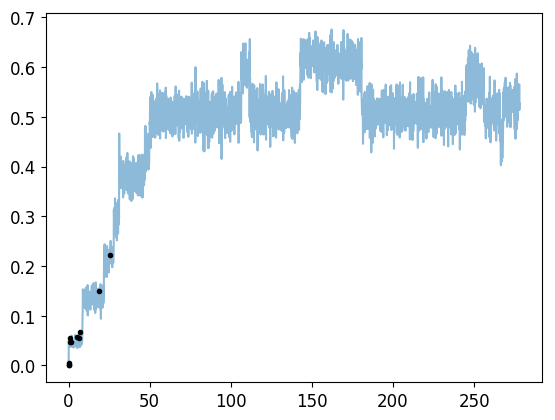

In [322]:
plt.plot(times, msds, alpha=0.5)
plt.plot(dft_times_plot, dft_msds_plot, 'k.', MarkerSize=6)

plt.show()

# Activation profile

In [59]:
# reconstruct solid state temperature ramp otf model
otf_file = '/Users/jonpvandermause/Research/GP/data/Al_Temperature_Ramp/\
Al_Ramp2_3-26/otf_run.out'

otf_obj = otf_parser.OtfAnalysis(otf_file)

cell = np.eye(3) * 8.092
kernel = kernels.two_body
kernel_grad = kernels.two_body_grad
algo = 'BFGS'
call_no = 17
cutoffs = np.array([5.4])

prev_hyps = otf_obj.gp_hyp_list[call_no-1][-1]
new_hyps = np.array([prev_hyps[0], prev_hyps[1], prev_hyps[-1]])

gp_model = otf_obj.make_gp(cell, kernel, kernel_grad, algo, call_no, cutoffs,
                           hyps=new_hyps)
gp_model.hyp_labels = ['sig2', 'ls2', 'noise']

In [60]:
# get activation of ramp gp model
fcc_cell = np.eye(3) * 8.092 / 2
species = ['Al']*31
nop = 100
cutoff = 5.4
xval = np.linspace(0, 1, nop)

store_res = analyze_gp.vac_diff_fcc(gp_model, cell, fcc_cell, species, cutoff, nop)

In [61]:
# get dft profile
barrier_file = '/Users/jonpvandermause/Research/GP/data/Aluminum/Al_Barrier/barrier.txt'
energies, forces, positions = activation_parser.parse_barrier_file(barrier_file)

dft_profile = []
for force in forces:
    dft_profile.append(force[0,0])

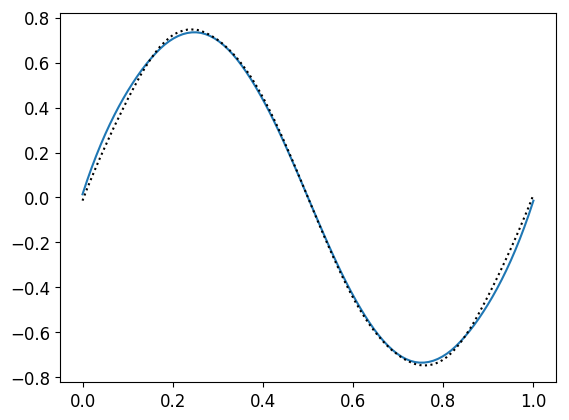

In [62]:
plt.plot(xval, store_res[0])
plt.plot(xval, dft_profile, 'k:')
plt.show()

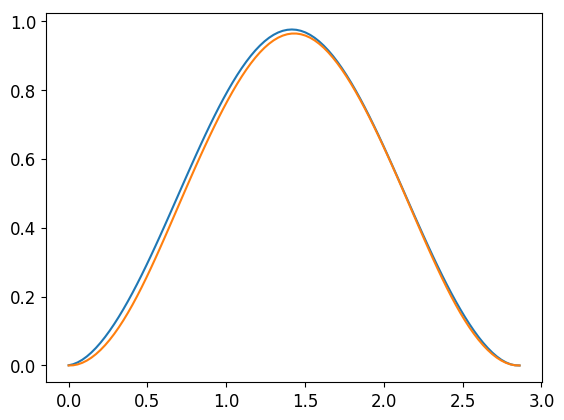

0.9747363794281719


In [63]:
# create 2x2x2 fcc supercell with atom 0 removed
nop = 100
alat = fcc_cell[0, 0]
fcc_unit = crystals.fcc_positions(alat)
fcc_super = crystals.get_supercell_positions(2, fcc_cell, fcc_unit)
vac_super = copy.deepcopy(fcc_super)
vac_super.pop(0)
vac_super = np.array(vac_super)

# create list of positions for the migrating atom
start_pos = vac_super[0]
end_pos = np.array([0, 0, 0])
diff_vec = end_pos - start_pos
test_list = []
step = diff_vec / (nop - 1)

step_mag = np.sqrt(step[0]**2 + step[1]**2)
fin_dist = np.sqrt(start_pos[0]**2 + start_pos[1]**2)
dists = np.linspace(0,fin_dist, nop)

fcc_cell = np.eye(3) * 8.092 / 2
alat = fcc_cell[0, 0]

test_fc = store_res[0,:]
test_en = []
en_curr = 0

for n in range(len(test_fc)):
    en_curr += np.sqrt(2) * test_fc[n] * step_mag
    test_en.append(en_curr)

plt.plot(dists, np.array(test_en))
plt.plot(dists, dft_act)
plt.show()

print(max(test_en))
    

In [53]:
# reconstruct solid state temperature ramp otf model
vac_file = '/Users/jonpvandermause/Research/GP/data/Al_Temperature_Ramp/Vacancy_Run_3-27/otf_run.out'
cell = np.eye(3) * 8.092
otf_vac = otf_parser.OtfAnalysis(vac_file)

vac_gp = otf_vac.make_gp(cell=cell, init_gp=gp_model)

In [54]:
vac_gp.hyps

array([-0.19981548,  0.83039351,  0.06323106])

In [55]:
# get activation of ramp gp model
fcc_cell = np.eye(3) * 8.092 / 2
species = ['Al']*31
nop = 100
cutoff = 5.4
xval = np.linspace(0, 1, nop)

store_res = analyze_gp.vac_diff_fcc(vac_gp, cell, fcc_cell, species, cutoff, nop)

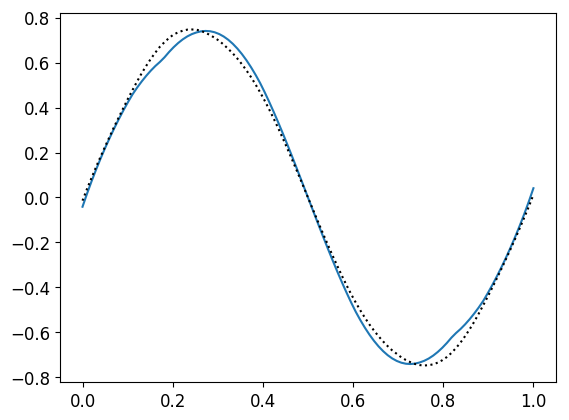

In [56]:
plt.plot(xval, store_res[0])
plt.plot(xval, dft_profile, 'k:')
plt.show()

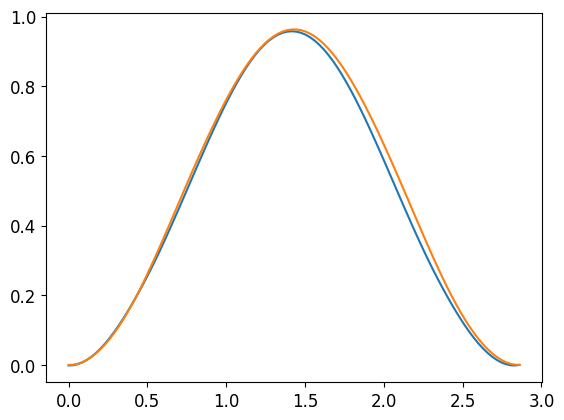

0.9577758899070582


In [58]:
# create 2x2x2 fcc supercell with atom 0 removed
nop = 100
alat = fcc_cell[0, 0]
fcc_unit = crystals.fcc_positions(alat)
fcc_super = crystals.get_supercell_positions(2, fcc_cell, fcc_unit)
vac_super = copy.deepcopy(fcc_super)
vac_super.pop(0)
vac_super = np.array(vac_super)

# create list of positions for the migrating atom
start_pos = vac_super[0]
end_pos = np.array([0, 0, 0])
diff_vec = end_pos - start_pos
test_list = []
step = diff_vec / (nop - 1)

step_mag = np.sqrt(step[0]**2 + step[1]**2)
fin_dist = np.sqrt(start_pos[0]**2 + start_pos[1]**2)
dists = np.linspace(0,fin_dist, nop)

fcc_cell = np.eye(3) * 8.092 / 2
alat = fcc_cell[0, 0]

test_fc = store_res[0,:]
test_en = []
en_curr = 0

for n in range(len(test_fc)):
    en_curr += np.sqrt(2) * test_fc[n] * step_mag
    test_en.append(en_curr)

plt.plot(dists, np.array(test_en))
plt.plot(dists, dft_act)
plt.show()

print(max(test_en))
    

# Vacancy activation profile using liquid model

In [19]:
# reconstruct solid state temperature ramp otf model
otf_file = '/Users/jonpvandermause/Research/GP/data/Al_Temperature_Ramp/\
Al_Ramp2_3-26/otf_run.out'

otf_obj = otf_parser.OtfAnalysis(otf_file)

cell = np.eye(3) * 8.092
kernel = kernels.two_plus_three_body
kernel_grad = kernels.two_plus_three_body_grad
algo = 'BFGS'
cutoffs = np.array([7, 4.5])

gp_model = otf_obj.make_gp(cell, kernel, kernel_grad, algo, cutoffs=cutoffs)

In [21]:
gp_model.hyps

array([-1.11604476e+00,  1.25338581e+00, -3.89372613e-04,  4.96196024e-01,
        7.97061077e-02])

In [22]:
# get activation of ramp gp model
fcc_cell = np.eye(3) * 8.092 / 2
species = ['Al']*31
nop = 100
cutoff = 7
xval = np.linspace(0, 1, nop)

store_res = analyze_gp.vac_diff_fcc(gp_model, cell, fcc_cell, species, cutoff, nop)

In [23]:
np.save('liq_profile', store_res)

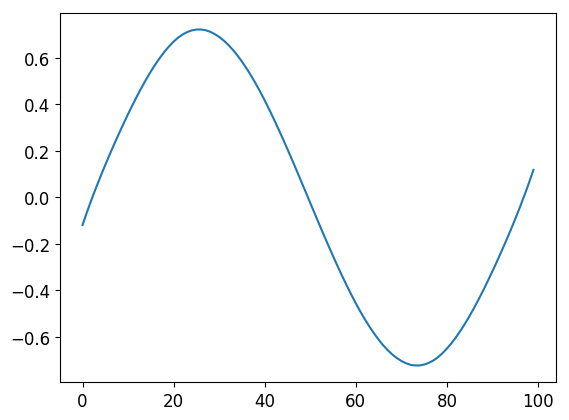

In [24]:
plt.plot(store_res[0])
plt.show()

In [25]:
# get dft profile
barrier_file = '/Users/jonpvandermause/Research/GP/data/Aluminum/Al_Barrier/barrier.txt'
energies, forces, positions = activation_parser.parse_barrier_file(barrier_file)

dft_profile = []
for force in forces:
    dft_profile.append(force[0,0])

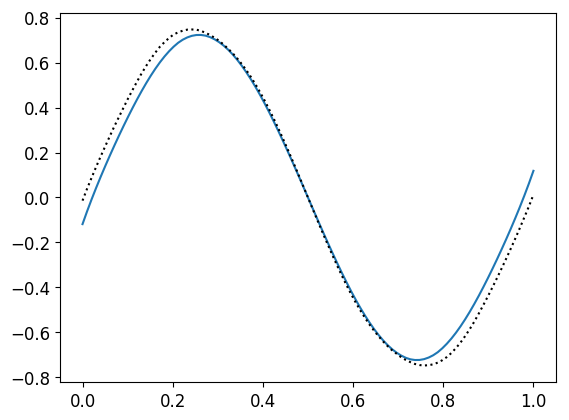

In [26]:
plt.plot(xval, store_res[0])
plt.plot(xval, dft_profile, 'k:')
plt.show()

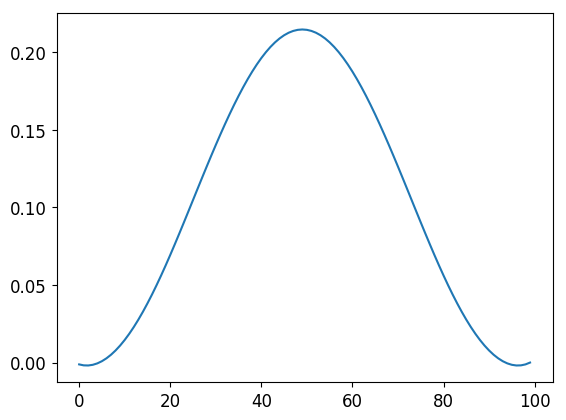

In [36]:
plt.plot(np.cumsum(store_res[0])*0.01)
plt.show()

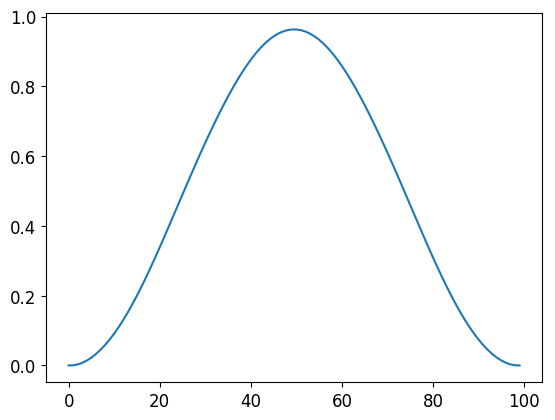

In [42]:
dft_act = (np.array(energies) - energies[0])*13.6056980659
plt.plot(dft_act)
plt.show()

In [39]:
# create 2x2x2 fcc supercell with atom 0 removed
nop = 100
alat = fcc_cell[0, 0]
fcc_unit = crystals.fcc_positions(alat)
fcc_super = crystals.get_supercell_positions(2, fcc_cell, fcc_unit)
vac_super = copy.deepcopy(fcc_super)
vac_super.pop(0)
vac_super = np.array(vac_super)

# create list of positions for the migrating atom
start_pos = vac_super[0]
end_pos = np.array([0, 0, 0])
diff_vec = end_pos - start_pos
test_list = []
step = diff_vec / (nop - 1)

step_mag = np.sqrt(step[0]**2 + step[1]**2)
fin_dist = np.sqrt(start_pos[0]**2 + start_pos[1]**2)
dists = np.linspace(0,fin_dist, nop)

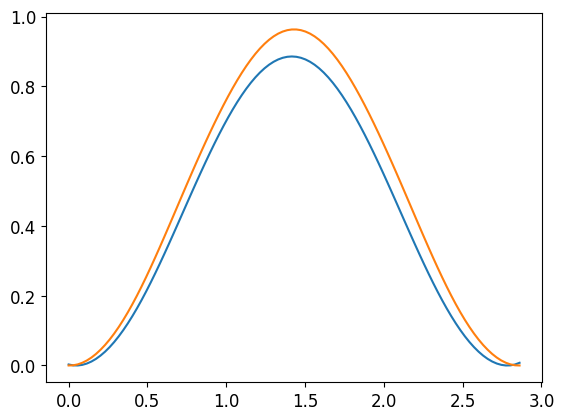

0.8778783072414963


In [45]:
fcc_cell = np.eye(3) * 8.092 / 2
alat = fcc_cell[0, 0]

test_fc = store_res[0,:]
test_en = []
en_curr = 0

for n in range(len(test_fc)):
    en_curr += np.sqrt(2) * test_fc[n] * step_mag
    test_en.append(en_curr)

plt.plot(dists, np.array(test_en)-min(test_en))
plt.plot(dists, dft_act)
plt.show()

print(max(test_en))
    

In [46]:
max(np.array(test_en)-min(test_en))

0.8855711458078039

In [47]:
max(dft_act)

0.962914844704566

In [48]:
max(dft_act)-max(np.array(test_en)-min(test_en))

0.07734369889676207